- This notebook is to compare some summary statistics between oma releases (number and size of OMA Groups, HOGs, added or removed genomes/taxa levels, number of homoeolog pairs, etc)
- By: Natasha Glover
- Last updated: 13 Aug 2018


# Setup

In [1]:
# Scientific libraries
import numpy as np
#from scipy import stats
import pandas as pd
import tables

#basic python libraries
import re

# Pyoma libraries
from pyoma.browser import sanitychecks

# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nglover/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/nglover/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Aesthetics

In [3]:
# Extra options
pd.set_option('max_colwidth',200)
pd.options.display.max_rows = 150

#style options
%matplotlib inline
plt.style.use('ggplot')

#seaborn options
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=1.5)
sns.set_style('whitegrid')
palette="husl"

## Mounting the oma browser directory

To compare oma browser releases, I use the hdf5 file from each. However, since they are so big (~50 Gb each), I mount the directory on vital-it where they are contained. This is done with sshfs and needs to be mounted before the following analyses. The following command is done from command line:
- sshfs nglover@prd.vital-it.ch:/scratch/ul/projects/cdessimo/oma-browser ~/oma_mount

## Parameters

TODO: Make it so that it just detects all the databases automatically and then we can run the notebook automatically after each release.

In [3]:
#directory containing the different oma browser releases
oma_browser_dir = "/Users/nglover/oma_mount/"

#list of 4 releases (strings) to be compared (only exactly 4 for now)
#note they will be plotted and presented in the order specified in list
releases = ["All.May2016", "All.Mar2017", "All.Dec2017", "All.Jun2018"]

# Running the sanity checks

The following code does all the heavy lifting and uses the sanitychecks2 library from pyoma. Since this involves making many computations, especially from the Entries table in each database, this could take a while to run (~40 minutes).

In [4]:
import importlib
importlib.reload(sanitychecks2)

#list of sanity (release) objects, each one corresponding to a different release
sanity_sessions = []

for release in releases:
    release_obj = sanitychecks2.SanitySession(oma_browser_dir, release)
    sanity_sessions.append(release_obj)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dim

All.May2016 done
All.Mar2017 done


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/Level/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


All.Dec2017 done
All.Jun2018 done


# Functions

In [ ]:
#TODO add these functions to the sanity checks module

In [216]:
def _return_group_object(release_obj, group):
    if group == "hog":
        group_obj = release_obj.all_hogs
    if group == "omagroup":
        group_obj = release_obj.omagroups
    return group_obj

def count_nb_groups(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release    
    return df.groupby('release').size().item()

def get_nb_genes_per_group_df(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release
    df.reset_index(inplace=True) 
    df.rename({0:"nb_genes", "index":group}, inplace=True, axis=1)    
    return df

def sort_df_by_release(df):
    df.release = df.release.astype("category")
    df.release.cat.set_categories(releases, inplace=True)
    df = df.sort_values("release")
    return df

def make_countplot_by_release(df, releases, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    ax = sns.countplot(x="release", data=df, order=releases, palette="husl")
    ax.set_title(title)
    return ax

def get_differences_in_genomes_or_taxa(df, old_release, new_release, genomes_or_taxa):
    '''old_release and new_release should be sanity session objects'''
    
    if genomes_or_taxa == "genomes":
        added = list(set(new_release.species) - set(old_release.species))
        removed = list(set(old_release.species) - set(new_release.species))
        
    if genomes_or_taxa == "taxa":
        added = list(set(new_release.all_hog_lvls) - set(old_release.all_hog_lvls))
        removed = list(set(old_release.all_hog_lvls) - set(new_release.all_hog_lvls))
        added = [x.decode("utf-8") for x in added]
        removed = [x.decode("utf-8") for x in removed]
    res = {'added':added, 'removed': removed}
    return res

def decode_column_in_df(df, column_to_decode):
    df[column_to_decode] = df.apply(lambda x: x[column_to_decode].decode("utf-8"), axis=1)
    return df

def make_boxplot_by_release(df, releases, column_to_plot, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[0], palette=palette, order=releases)
    ax[0].set_title("Outliers shown")
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[1], showfliers=False, palette=palette, order=releases)
    ax[1].set_title("No outliers shown")
    plt.suptitle(title)
    plt.subplots_adjust(top=0.75)
    plt.show()
    
def get_prop_with_n_genes(df, releases, nb_genes=2):
    '''get number of groups per release
    param releases is the list of string releases'''
    df1 = df.groupby('release').size().reset_index()
    df1.rename({0:'total_nb_groups'}, axis=1, inplace=True)

    #get groups with n genes
    df2 = df[df['nb_genes']==nb_genes].groupby('release').size().reset_index()
    df2.rename({0:'nb_groups_with_'+str(nb_genes)+'_genes'}, axis=1, inplace=True)
    
    #get proportion
    df3 = pd.merge(left=df1, right=df2, how="left", on="release")
    df3['prop_groups_'+str(nb_genes)+'_genes'] = df3['nb_groups_with_'+str(nb_genes)+'_genes']/ df3['total_nb_groups']
    df3.set_index("release", inplace=True)
    df3 = df3.reindex(releases)
    df3.reset_index(level=0, inplace=True)
    return df3

def get_total_nb_groups(df):
    df = df.groupby('release').size().reset_index()
    df.rename({0:"nb_genomes"}, axis=1, inplace=True)
    df = sort_df_by_release(df) 
    return df

def get_summary_stats(df, column_to_summarize):
    df= df[['release',column_to_summarize]].groupby('release').describe().reset_index()
    df.columns = df.columns.droplevel()
    df = df.rename({'':'release'}, axis=1)
    df = sort_df_by_release(df)
    return df

def plot_proportions_of_groups_with_n_genes(low_genes_df, list_of_columns_to_plot,\
                                            title="Don't forget a title", rename_cols=False):
    
    if rename_cols==True:
        low_genes_df = rename_proportion_columns(low_genes_df)
        list_of_columns_to_plot = rename_proportion_columns(low_genes_df).columns[1:5]
        
    
    #melt dataframe
    melted_low_genes_df = pd.melt(low_genes_df, id_vars=['release'], \
                                  value_vars=list_of_columns_to_plot)
    melted_low_genes_df.rename({"variable": "nb genes in group", "value": "proportion of groups"}, \
                               axis=1, inplace=True)
    
    #make plot
    fig, ax= plt.subplots(figsize=(8,10))
    sns.pointplot(x="release", y="proportion of groups", hue="nb genes in group", data=melted_low_genes_df, \
                 palette=palette)
    #plt.legend(loc="upper right")
    plt.ylim(0,.7)
    plt.title(title)
    plt.show()

def get_low_genes_df(df, releases, list_of_gene_numbers=[2,3,4,5]):
    '''makes a dataframe with proportion of genes with n number for each release.'''
    low_genes_df = pd.DataFrame.from_items([('release', releases)])

    for i in range(list_of_gene_numbers[0],list_of_gene_numbers[-1]+1):
        tmp_df = pd.DataFrame(get_prop_with_n_genes(df, releases, i))
        low_genes_df = pd.merge(left=low_genes_df, right=tmp_df[['release',tmp_df.columns[-1]]],\
                                how="left", on="release")

    low_genes_df['total_nb_groups'] = get_prop_with_n_genes(df, releases, 2)['total_nb_groups']
    return low_genes_df

def rename_proportion_columns(df):
    columns = df.columns
    new_columns = {}
    for column in columns:
        if "prop_groups" in column:
            matchObj = re.match(r'prop_groups_(.*)_genes', column)
            try:
                new_column = matchObj.group(1)
                new_columns[column] = new_column
            except:
                print("no match")
    
    df = df.rename(new_columns, axis=1)
    return df


# Compare Genomes

In [6]:
#get genome dataframe
genome_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_items([('genomes', release.species)])
    tmp_df['release'] = release.release
    genome_df = genome_df.append(tmp_df)

## Nb of genomes

In [7]:
get_total_nb_groups(genome_df)

,release,nb_genomes
3,All.May2016,2024
2,All.Mar2017,2085
0,All.Dec2017,2103
1,All.Jun2018,2167


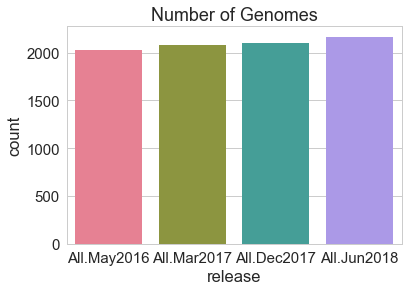

In [57]:
make_countplot_by_release(genome_df, releases, "Number of Genomes")

## Genomes added

In [13]:
#latest genomes added
genome1_df = pd.DataFrame(sanity_sessions[2].genome_table.read())
genome1_df = decode_column_in_df(genome1_df, "UniProtSpeciesCode")
genome2_df = pd.DataFrame(sanity_sessions[3].genome_table.read())
genome2_df = decode_column_in_df(genome2_df, "UniProtSpeciesCode")

diff = get_differences_in_genomes_or_taxa(genome_df, sanity_sessions[2], sanity_sessions[3], "genomes")
genome2_df.loc[genome2_df['UniProtSpeciesCode'].isin(diff['added'])] 

,NCBITaxonId,UniProtSpeciesCode,TotEntries,TotAA,EntryOff,SciName,CommonName,SynName,Release,Url,Source,Date,IsPolyploid
7,490899,DESA1,1470,400448,11580,b'Desulfurococcus amylolyticus (strain DSM 18924 / JCM 16383 / VKM B-2413 / 1221n)',b'',b'',"b'16-JUN-2009 (Rel. 107, Last updated, Version 3)'",b'http://www.expasy.org/sprot/hamap/DESA1.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP001140_GR.dat.gz',1245621600,False
110,990316,METSG,2782,819844,261938,b'Methanothrix soehngenii (strain ATCC 5969 / DSM 3671 / JCM 10134 / NBRC 103675 / OCM 69 / GP-6)',b'',b'',"b'14-JUL-2011 (Rel. 109, Last updated, Version 3)'",b'http://www.expasy.org/sprot/hamap/METSG.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=CP002565',1345413600,False
145,1579370,ARCG5,1339,374442,336028,b'Archaeon GW2011_AR10',b'',b'',b'ENA; GCA_000830275.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000830275.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000830275.1',1522188000,False
146,1579373,ARCG3,1308,357400,337367,b'Archaeon GW2011_AR15',b'',b'',b'ENA; GCA_000830295.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000830295.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000830295.1',1522188000,False
147,1579378,ARCG6,1010,255387,338675,b'Archaeon GW2011_AR20',b'',b'',b'ENA; GCA_000830315.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000830315.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000830315.1',1522188000,False
148,1579367,ARCGX,1028,256220,339685,b'Archaeon GW2011_AR5',b'',b'',b'ENA; GCA_000806115.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000806115.1',b'http://www.ebi.ac.uk/ena/data/view/GCA_000806115.1',1522188000,False
253,685727,RHOH1,4598,1540306,679298,b'Rhodococcus hoagii (strain 103S)',b'',b'',"b'08-MAR-2011 (Rel. 129, Last updated, Version 1)'",b'http://www.expasy.org/sprot/hamap/RHOH1.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/FN563149_GR.dat.gz',1302472800,False
269,1703,BRELN,3434,1150451,768064,b'Brevibacterium linens',b'',b'',b'Ensembl Bacteria 38; Brevibacterium_linens_AE038-8_v1.0',b'http://bacteria.ensembl.org/Brevibacterium_linens',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-38/embl/brevibacterium_linens',1518735600,False
290,743718,ISOV2,2881,987996,835350,b'Isoptericola variabilis (strain 225)',b'',b'',b'Ensembl Bacteria 37; ASM21510v1',b'http://bacteria.ensembl.org/Isoptericola_variabilis_225',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-37/embl/isoptericola_variabilis_225',1510095600,False
306,267747,CUTAK,2294,760875,911171,b'Cutibacterium acnes (strain DSM 16379 / KPA171202)',b'',b'',"b'02-MAR-2010 (Rel. 118, Last updated, Version 101)'",b'http://www.expasy.org/sprot/hamap/CUTAK.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/AE017283_GR.dat.gz',1269212400,False


## Genomes removed

In [14]:
genome1_df.loc[genome1_df['UniProtSpeciesCode'].isin(diff['removed'])] 

,NCBITaxonId,UniProtSpeciesCode,TotEntries,TotAA,EntryOff,SciName,CommonName,SynName,Release,Url,Source,IsPolyploid
7,490899,DESK1,1470,400448,11580,b'Desulfurococcus kamchatkensis (strain DSM 18924 / JCM 16383 / VKM B-2413 / 1221n)',b'',b'',"b'16-JUN-2009 (Rel. 107, Last updated, Version 3)'",b'http://www.expasy.org/sprot/hamap/DESK1.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP001140_GR.dat.gz',False
109,990316,METCG,2782,819844,259580,b'Methanosaeta concilii (strain ATCC 5969 / DSM 3671 / JCM 10134 / NBRC 103675 / OCM 69 / GP-6)',b'',b'',"b'14-JUL-2011 (Rel. 109, Last updated, Version 3)'",b'http://www.expasy.org/sprot/hamap/METCG.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=CP002565',False
249,685727,RHOE1,4598,1540306,674613,b'Rhodococcus equi (strain 103S)',b'',b'',"b'08-MAR-2011 (Rel. 129, Last updated, Version 1)'",b'http://www.expasy.org/sprot/hamap/RHOE1.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/FN563149_GR.dat.gz',False
300,267747,PROAC,2294,760875,900171,b'Propionibacterium acnes (strain KPA171202 / DSM 16379)',b'',b'',"b'02-MAR-2010 (Rel. 118, Last updated, Version 101)'",b'http://www.expasy.org/sprot/hamap/PROAC.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/AE017283_GR.dat.gz',False
917,190650,CAUCR,3714,1204535,2798281,b'Caulobacter crescentus (strain ATCC 19089 / CB15)',b'',b'',"b'01-SEP-2009 (Rel. 110, Last updated, Version 111)'",b'http://www.expasy.org/sprot/hamap/CAUCR.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/AE005673_GR.dat.gz',False
918,565050,CAUCN,3852,1223896,2801995,b'Caulobacter crescentus (strain NA1000 / CB15N)',b'',b'',"b'13-OCT-2009 (Rel. 112, Last updated, Version 7)'",b'http://www.expasy.org/sprot/hamap/CAUCN.html',b'ftp://ftp.ebi.ac.uk/pub/databases/genome_reviews/dat/cellular/CP001340_GR.dat.gz',False
1503,317025,THICR,2187,722179,5017519,b'Thiomicrospira crunogena (strain XCL-2)',b'',b'',"b'30-JAN-2014 (Rel. 119, Last updated, Version 5)'",b'http://www.expasy.org/sprot/hamap/THICR.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=CP000109',False
1557,643562,DESAO,3268,1066402,5214347,b'Desulfovibrio aespoeensis (strain ATCC 700646 / DSM 10631 / Aspo-2)',b'',b'',"b'20-JUN-2014 (Rel. 121, Last updated, Version 3)'",b'http://www.expasy.org/sprot/hamap/DESAO.html',b'http://www.ebi.ac.uk/ena/data/view/CP002431',False
1561,1322246,DESPC,3342,1080842,5228342,b'Desulfovibrio piezophilus (strain DSM 21447 / JCM 15486 / C1TLV30)',b'',b'',"b'27-FEB-2015 (Rel. 123, Last updated, Version 3)'",b'http://www.expasy.org/sprot/hamap/DESPC.html',b'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=embl&id=FO203427',False
2015,2015173,CERBI,16303,6761243,9214195,b'Cerapachys biroi',b'Ant',b'',"b'30-APR-2014 (Rel. 120, Last updated, Version 1)'",b'http://www.uniprot.org/proteomes/UP000053097',b'http://www.ebi.ac.uk/ena/data/view/KK107008-KK111586&display=text&expanded=true',False


# Compare number of proteins

In [15]:
#note this include ASVs
df = pd.DataFrame()
for release in sanity_sessions:
    df = df.append({'release': release.release, "nb_entries": release.entries_table.attrs.NROWS}, ignore_index=True)
    
sort_df_by_release(df)

,nb_entries,release
0,10455627.0,All.May2016
1,11404511.0,All.Mar2017
2,11624503.0,All.Dec2017
3,12691751.0,All.Jun2018


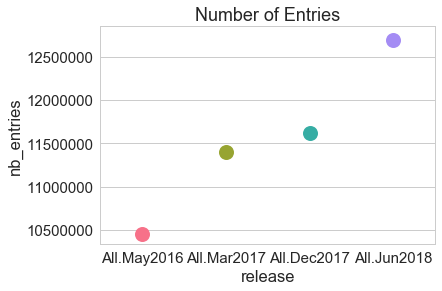

In [58]:
sns.stripplot(x="release", y="nb_entries",data=df, order=releases, size=15, palette="husl")
plt.title("Number of Entries")
plt.ticklabel_format(style='plain', axis='y')

# Compare OMA Groups

In [17]:
#get omagroups df
omagroups_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "omagroup")
    omagroups_df = omagroups_df.append(tmp_df, ignore_index=True)

## Nb of omagroups

In [18]:
#total number of omagroups
get_total_nb_groups(omagroups_df)

,release,nb_genomes
3,All.May2016,1034997
2,All.Mar2017,779787
0,All.Dec2017,798760
1,All.Jun2018,842789


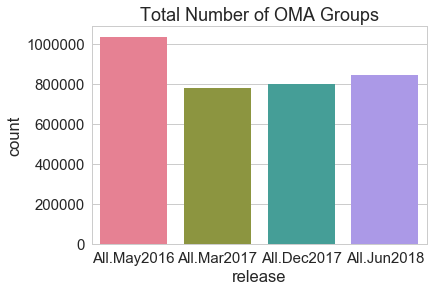

In [59]:
make_countplot_by_release(omagroups_df, releases, title="Total Number of OMA Groups")

## Nb genes per OMA Groups summary stats

In [22]:
get_summary_stats(omagroups_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
3,All.May2016,1034997.0,8.283003,27.151089,2.0,2.0,3.0,6.0,1720.0
2,All.Mar2017,779787.0,11.619314,48.575176,2.0,2.0,3.0,7.0,2010.0
0,All.Dec2017,798760.0,11.539356,48.279524,2.0,2.0,3.0,7.0,2023.0
1,All.Jun2018,842789.0,11.594424,48.289840,2.0,2.0,3.0,7.0,2079.0


## Plot distributions

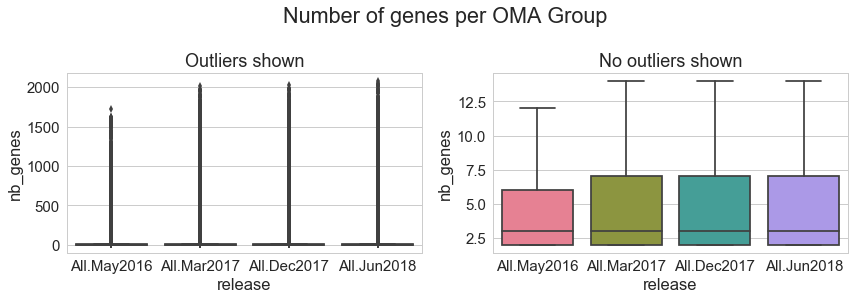

In [63]:
make_boxplot_by_release(omagroups_df, "nb_genes","Number of genes per OMA Group")

## Groups with low numbers of genes

In [126]:
low_genes_df = get_low_genes_df(omagroups_df, releases)
low_genes_df

,release,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,prop_groups_5_genes,total_nb_groups
0,All.May2016,0.399239,0.163242,0.094130,0.061720,1034997
1,All.Mar2017,0.434266,0.121175,0.074918,0.062639,779787
2,All.Dec2017,0.428975,0.124880,0.075933,0.061164,798760
3,All.Jun2018,0.429863,0.121433,0.076717,0.061436,842789


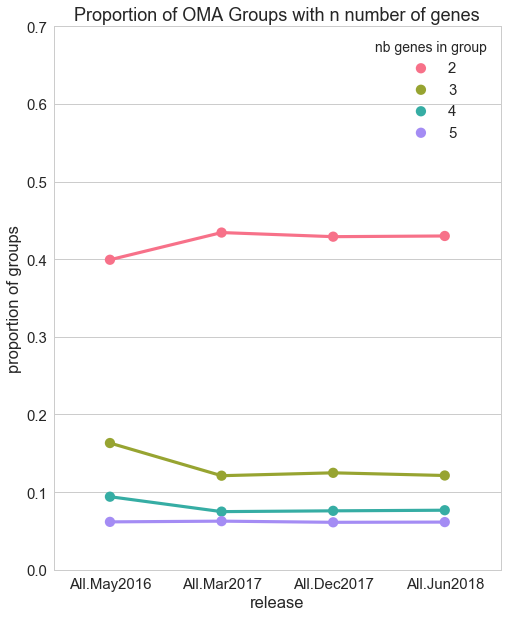

In [127]:
low_genes_df.rename({'prop_groups_2_genes':"2",'prop_groups_3_genes':"3",\
                     'prop_groups_4_genes':"4",'prop_groups_5_genes':"5"}, axis=1, inplace=True)


plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of OMA Groups with n number of genes")

# Compare HOGs (subhogs)

In [128]:
#get hog df
hog_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "hog")
    hog_df = hog_df.append(tmp_df, ignore_index=True)

## Nb of hogs

In [129]:
#total number of hogs
get_total_nb_groups(hog_df)

,release,nb_genomes
3,All.May2016,2252466
2,All.Mar2017,2676228
0,All.Dec2017,2717565
1,All.Jun2018,2882980


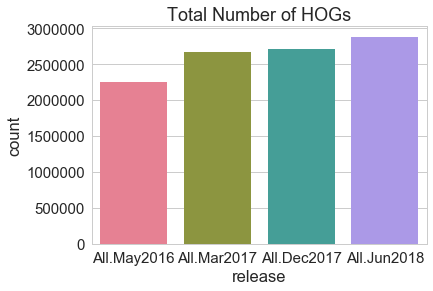

In [130]:
make_countplot_by_release(hog_df, releases, title="Total Number of HOGs")

## Nb genes per HOG summary stats

In [133]:
get_summary_stats(hog_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
3,All.May2016,2252466.0,3.768766,15.285949,1.0,1.0,1.0,2.0,1737.0
2,All.Mar2017,2676228.0,3.528828,16.305082,1.0,1.0,1.0,2.0,1744.0
0,All.Dec2017,2717565.0,3.534553,16.208430,1.0,1.0,1.0,2.0,1746.0
1,All.Jun2018,2882980.0,3.536418,16.198242,1.0,1.0,1.0,2.0,1775.0


## Plot distributions

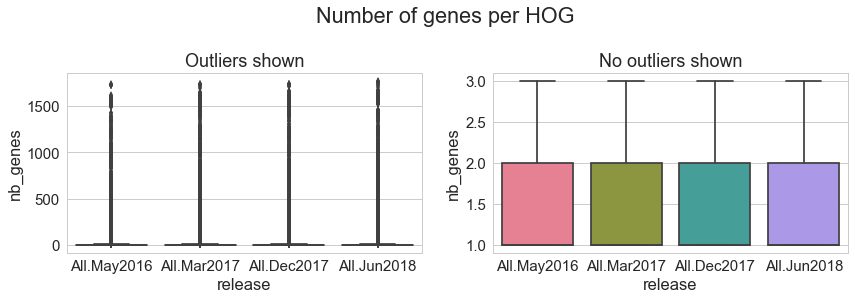

In [217]:
make_boxplot_by_release(hog_df, releases, "nb_genes", "Number of genes per HOG")

## HOGs with low numbers

In [147]:
low_genes_df = get_low_genes_df(hog_df, releases, [1,2,3,4])
low_genes_df

,release,prop_groups_1_genes,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,total_nb_groups
0,All.May2016,0.566203,0.190329,0.066491,0.037233,2252466
1,All.Mar2017,0.588565,0.202079,0.062200,0.031039,2676228
2,All.Dec2017,0.585328,0.201484,0.065206,0.031485,2717565
3,All.Jun2018,0.594853,0.199572,0.058460,0.031824,2882980


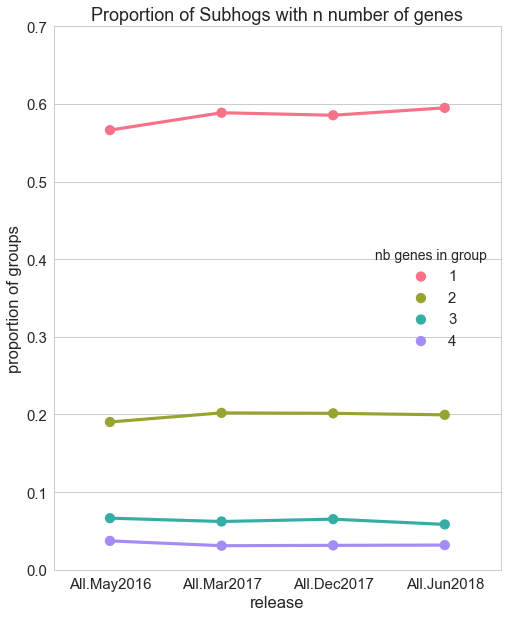

In [218]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Subhogs with n number of genes",\
                                       rename_cols=True)

# Compare families (root hogs)

In [209]:
hog_df['fam'] = hog_df.apply(lambda x: int(x['hog'][4:11]), axis=1)
grouped = hog_df.groupby(['release','fam'])
fam_df = grouped.sum().reset_index()

## Nb of families

In [210]:
#total number of families
get_total_nb_groups(fam_df)

,release,nb_genomes
3,All.May2016,432519
2,All.Mar2017,589223
0,All.Dec2017,603285
1,All.Jun2018,614588


## Nb genes per fam summary stats

In [212]:
get_summary_stats(fam_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
3,All.May2016,432519.0,19.626925,123.654094,2.0,2.0,3.0,8.0,17256.0
2,All.Mar2017,589223.0,16.027798,376.403707,2.0,2.0,3.0,6.0,217038.0
0,All.Dec2017,603285.0,15.921792,377.489090,2.0,2.0,3.0,6.0,220984.0
1,All.Jun2018,614588.0,16.589034,208.710918,2.0,2.0,3.0,7.0,116081.0


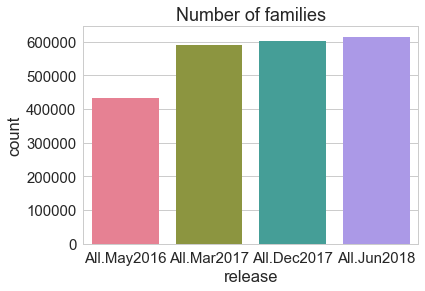

In [213]:
make_countplot_by_release(fam_df, releases, title="Number of families")

## Plot distributions

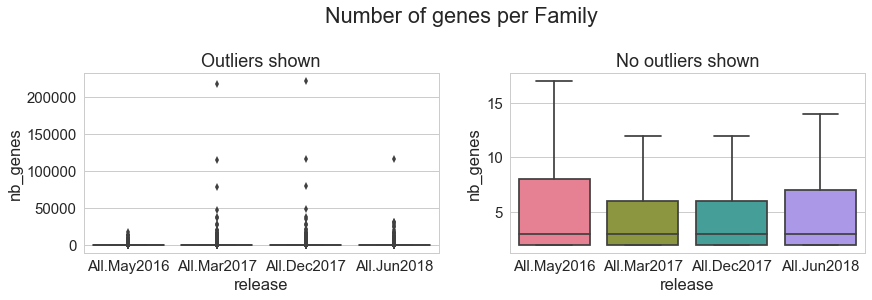

In [219]:
make_boxplot_by_release(fam_df, releases, "nb_genes","Number of genes per Family")

## Families with low numbers

In [226]:
low_genes_df = get_low_genes_df(fam_df, releases, [2,3,4,5])
low_genes_df

,release,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,prop_groups_5_genes,total_nb_groups
0,All.May2016,0.426314,0.132864,0.077569,0.053632,432519
1,All.Mar2017,0.455921,0.158453,0.078602,0.050998,589223
2,All.Dec2017,0.448829,0.163876,0.081030,0.046845,603285
3,All.Jun2018,0.448442,0.127899,0.083209,0.047240,614588


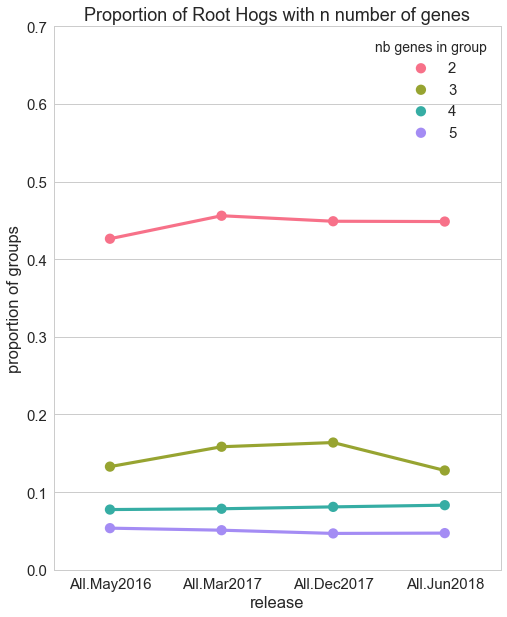

In [227]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Root Hogs with n number of genes",\
                                       rename_cols=True)

# Compare at different taxa levels

In [229]:
tax_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_dict(release.all_hog_lvls, orient="index")
    tmp_df = tmp_df.rename({0:'nb_hogs'}, axis=1)
    tmp_df = tmp_df.reset_index()
    tmp_df['release'] = release.release
    tax_df = tax_df.append(tmp_df)

tax_df.rename({'index':'taxa'}, axis=1, inplace=True)
tax_df['taxa'] = tax_df.apply(lambda x: x['taxa'].decode("utf-8"), axis=1)

## Nb of taxa levels

In [230]:
get_total_nb_groups(tax_df)

,release,nb_genomes
3,All.May2016,5458
2,All.Mar2017,2920
0,All.Dec2017,2956
1,All.Jun2018,3048


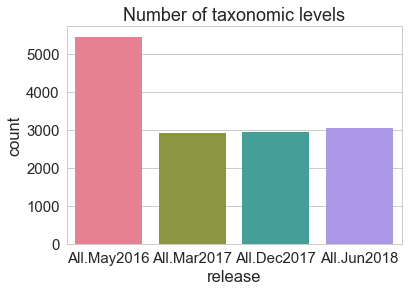

In [232]:
#number of taxa
make_countplot_by_release(tax_df, releases, title="Number of taxonomic levels")

## Nb hogs per taxa summary stats

In [233]:
#number of hogs per taxonomic level summary stats
get_summary_stats(tax_df, 'nb_hogs')

,release,count,mean,std,min,25%,50%,75%,max
3,All.May2016,5458.0,5243.927812,5774.193137,4.0,1943.00,3198.5,5666.00,67352.0
2,All.Mar2017,2920.0,5982.007877,7857.964114,69.0,2062.50,3533.0,5878.25,90253.0
0,All.Dec2017,2956.0,6009.267591,7858.234757,69.0,2078.75,3546.5,6002.50,90288.0
1,All.Jun2018,3048.0,6205.886483,8190.807309,69.0,2089.75,3597.0,6126.25,90818.0


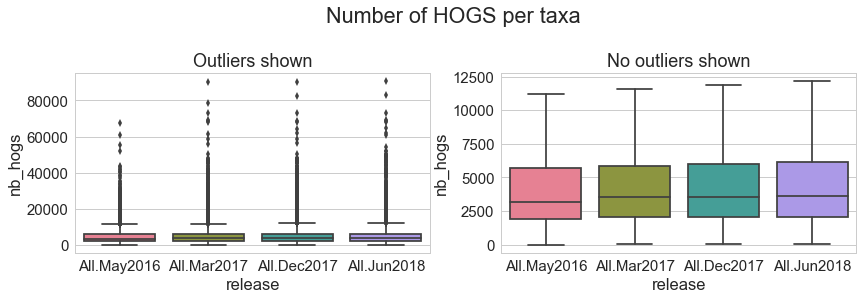

In [234]:
#distribution of number of hogs per taxa level
make_boxplot_by_release(tax_df, releases, 'nb_hogs', "Number of HOGS per taxa")

## Taxa added

In [329]:
old_release = sanity_sessions[-2]
new_release = sanity_sessions[-1]
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['added']

['Moraxella',
 'Rhodococcus hoagii (strain 103S)',
 'Dictyostelids',
 'Tylenchida',
 'Plasmodium fragile',
 'Microsporidia',
 'Schizosaccharomyces japonicus (strain yFS275 / FY16936)',
 'Myomorpha',
 'Hydrogenovibrio crunogenus (strain XCL-2)',
 'Buchnera aphidicola subsp. Schlechtendalia chinensis',
 'Thelazia callipaeda',
 'Providencia rettgeri (strain Dmel1)',
 'Wolbachia pipientis',
 'Kinetoplastida',
 'Chenopodium quinoa',
 'Spiruromorpha',
 'Gossypium raimondii',
 'Muroidea',
 'Verticillium dahliae (strain VdLs.17 / ATCC MYA-4575 / FGSC 10137)',
 'Plasmodium falciparum (isolate Palo Alto / Uganda)',
 'Isoptericola variabilis (strain 225)',
 'Trichormus',
 'Nicotiana attenuata',
 'Marchantia polymorpha',
 'Chlorobaculum tepidum (strain ATCC 49652 / DSM 12025 / NBRC 103806 / TLS)',
 'Meloidogyne hapla',
 'Caulobacter vibrioides (strain NA1000 / CB15N)',
 'Plasmodium falciparum (isolate Dd2)',
 'Plasmodium malariae',
 'Chinchilla lanigera',
 'Schizosaccharomyces',
 'Pan',
 'Dothistr

## Taxa removed

In [330]:
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['removed']

['Anabaena',
 'Thiomicrospira crunogena (strain XCL-2)',
 'Desulfovibrio aespoeensis (strain ATCC 700646 / DSM 10631 / Aspo-2)',
 'Coriolaceae',
 'Chlorobium tepidum (strain ATCC 49652 / DSM 12025 / NBRC 103806 / TLS)',
 'Propionibacterium acnes (strain KPA171202 / DSM 16379)',
 'Methanosaeta',
 'Caulobacter crescentus (strain ATCC 19089 / CB15)',
 'Clavibacter michiganensis',
 'Thermogladius cellulolyticus (strain 1633)',
 'Rhodococcus equi (strain 103S)',
 'Dictyosteliida',
 'Desulfurococcus kamchatkensis (strain DSM 18924 / JCM 16383 / VKM B-2413 / 1221n)',
 'Methanosaeta concilii (strain ATCC 5969 / DSM 3671 / JCM 10134 / NBRC 103675 / OCM 69 / GP-6)',
 'Hordeum vulgare var. distichon',
 'Desulfovibrio piezophilus (strain DSM 21447 / JCM 15486 / C1TLV30)',
 'Rhabditida',
 'Burkholderia lata (strain ATCC 17760 / LMG 22485 / NCIMB 9086 / R18194 / 383)',
 'Thioalkalimicrobium cyclicum (strain DSM 14477 / JCM 11371 / ALM1)',
 'Clostridium acidurici (strain ATCC 7906 / CIP 104303 / DSM 

## Taxa with 2 genes in family

The following analysis uses the latest release.

In [301]:
#get families with 2 genes
families_2_genes = fam_df[(fam_df['nb_genes']==2) & (fam_df['release']==releases[3])]['fam']

#open up latest h5 file
h5file = tables.open_file(oma_browser_dir+"/"+releases[3]+"/data/OmaServer.h5", "r")

#read hog level table and make df
hog_level_df = pd.DataFrame(h5file.root.HogLevel.read())

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/Level/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions 

In [322]:
#get rows with rootlevel taxa matching list of families w/ 2 genes
taxa_2_genes_at_root_df = hog_level_df[hog_level_df['Fam'].isin(families_2_genes)].\
                                                            drop_duplicates(subset='Fam').\
                                                            groupby('Level').\
                                                            size().\
                                                            reset_index().\
                                                            sort_values(0, ascending=False)
taxa_2_genes_at_root_df = taxa_2_genes_at_root_df.rename({0:"nb_families"}, axis=1)
taxa_2_genes_at_root_df = decode_column_in_df(taxa_2_genes_at_root_df, "Level")

In [331]:
#top 20 taxa with the most families consisting of 2 genes
taxa_2_genes_at_root_df[:20]

,Level,nb_families
661,Puccinia graminis,14508
154,Capitella,12189
121,Brassica,9013
499,Musa acuminata,8680
306,Eukaryota,6712
572,Oryza,5536
613,Phaeosphaeria nodorum,4888
107,Bilateria,4334
89,Bacteria,3838
719,Sarcocystidae,3345
